# Rice Yield Prediction: PyTorch LSTM (Seq_Len=3) with Optuna Tuning

## Overview
This notebook trains a **Long Short-Term Memory (LSTM)** network using **PyTorch** to predict Rice yields. 

**Updates:**
1.  **Sequence Length:** Increased to **3** to capture temporal dependencies (Last 3 years -> Current Year).
2.  **Initial Hyperparameters:** Updated based on previous Optuna results to provide a better baseline.

## Methodology
1.  **Data Processing:** 
    * Impute and Scale data.
    * Generate sliding window sequences of length 3, grouped by Area/Location.
2.  **Split:** Time-series split by Year on the generated sequences.
3.  **Model:** Stacked LSTM.
4.  **Optimization:** Optuna tuning.
5.  **Evaluation:** RMSE & R2.

In [1]:
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Optuna Viz
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_slice
from optuna.visualization import plot_param_importances

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.manual_seed(42)
np.random.seed(42)

/Users/pavin/Documents/GitHub/ML_project/.venv-1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


### 1. Data Loading & Preprocessing
To improve performance, we create **sequences of 3 years** for the LSTM input. This requires sorting by Area and Year and using a sliding window.

In [2]:
# Load Data
df = pd.read_parquet('Parquet/XY_version1.parquet')
TARGET_COL = 'Y_rice'
LAG_1_FEATURE = 'avg_yield_rice_1y'

# Clean Missing Targets
df_model = df.dropna(subset=[TARGET_COL]).copy()

# Identify Features (exclude metadata)
feature_cols = [c for c in df_model.columns if not c.startswith('Y_') and c not in ['year', 'area']]

# --- PREPROCESSING ---
# 1. Impute & Scale (Fit on Train, Transform All)
# We need to do this BEFORE creating sequences to ensure consistency
TRAIN_END_YEAR = 2016
VAL_END_YEAR = 2020

# Determine train population for fitting scaler
train_mask_fit = df_model['year'] < TRAIN_END_YEAR

imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

# Fit on training data subset
X_fit = df_model.loc[train_mask_fit, feature_cols]
imputer.fit(X_fit)
scaler.fit(imputer.transform(X_fit))

# Transform entire dataframe
df_model[feature_cols] = scaler.transform(imputer.transform(df_model[feature_cols]))

# --- SEQUENCE GENERATION ---
SEQ_LEN = 3

def create_sequences(data, seq_len, feat_cols, target_col, group_col='area', time_col='year'):
    """
    Creates (Batch, Seq, Feat) tensors using sliding window, grouped by area.
    """
    # Sort properly to ensure temporal order
    data = data.sort_values([group_col, time_col]).reset_index(drop=True)
    
    # Create shifted features for the window [t-(N-1), ..., t]
    # We will shift the dataframe 'down' to align past rows with current target
    # Note: shift(1) means t-1 moves to t's position.
    
    sequences = []
    # We want: [t-2, t-1, t]
    # Shift(2) brings t-2 to row t
    # Shift(1) brings t-1 to row t
    # Shift(0) is t
    for i in range(seq_len - 1, -1, -1):
        sequences.append(data[feat_cols].shift(i).values)
    
    # Stack to get (N, Seq_Len, Features)
    X_stacked = np.stack(sequences, axis=1)
    y_arr = data[target_col].values
    years_arr = data[time_col].values
    areas_arr = data[group_col].values
    
    # Validate Sequences: Ensure all steps in a sequence belong to the same Area
    # We check if Area at t == Area at t-(N-1)
    valid_mask = (data[group_col] == data[group_col].shift(seq_len - 1))
    # Also drop NaNs created by shifting
    valid_mask = valid_mask & ~data[feat_cols].shift(seq_len - 1).isna().any(axis=1)
    
    return X_stacked[valid_mask], y_arr[valid_mask], years_arr[valid_mask]

print(f"Generating sequences with length {SEQ_LEN}...")
X_seq, y_seq, years_seq = create_sequences(df_model, SEQ_LEN, feature_cols, TARGET_COL)

# --- SPLIT ---
mask_train = years_seq < TRAIN_END_YEAR
mask_val = (years_seq >= TRAIN_END_YEAR) & (years_seq < VAL_END_YEAR)
mask_test = years_seq >= VAL_END_YEAR

X_train_t = torch.tensor(X_seq[mask_train], dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_seq[mask_train], dtype=torch.float32).to(device)

X_val_t = torch.tensor(X_seq[mask_val], dtype=torch.float32).to(device)
y_val_t = torch.tensor(y_seq[mask_val], dtype=torch.float32).to(device)

X_test_t = torch.tensor(X_seq[mask_test], dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_seq[mask_test], dtype=torch.float32).to(device)

print(f"Train Shape: {X_train_t.shape}")
print(f"Val Shape:   {X_val_t.shape}")
print(f"Test Shape:  {X_test_t.shape}")

# Calculate Baseline (needs aligning with test set)
# We use the original dataframe to get the LAG_1 feature for the corresponding test rows
# (Actually, since we dropped rows during sequence generation, we must rely on index/matching or simpler logic)
# Simpler logic: Re-extract baseline for the valid indices found in sequence generation
# However, since we don't track indices easily, we can just assume 'Last Year Yield' is a feature in the input sequence.
# LAG_1_FEATURE is 'avg_yield_rice_1y'. In our sequence [t-2, t-1, t], the features at step 't' (index -1) contains lag1 of t+1? 
# No, features at row t are inputs for predicting y_t.
# 'avg_yield_rice_1y' at row t IS the yield of t-1. So that is our baseline prediction.
# We need the index of 'avg_yield_rice_1y' in feature_cols.

lag1_idx = feature_cols.index(LAG_1_FEATURE)
# Extract baseline predictions from the test input tensor (Last Step, Lag1 Feature)
# Note: Data is scaled. We must unscale it or scale y_test? 
# Better: use the raw y values for metric. The baseline feature is scaled.
# Reverse scaling for baseline:
y_pred_baseline_scaled = X_test_t[:, -1, lag1_idx].cpu().numpy()

# To unscale single feature is messy. Let's just re-fetch raw baseline for valid test rows.
# We sort df same way as create_sequences did
df_sorted = df_model.sort_values(['area', 'year']).reset_index(drop=True)
# Re-apply mask logic (copy-paste from func)
valid_mask = (df_sorted['area'] == df_sorted['area'].shift(SEQ_LEN - 1))
valid_mask = valid_mask & ~df_sorted[feature_cols].shift(SEQ_LEN - 1).isna().any(axis=1)
# Get valid rows
df_valid = df_sorted[valid_mask]
# Filter for test years
df_valid_test = df_valid[df_valid['year'] >= VAL_END_YEAR]

# Raw baseline from raw dataframe (unscaled)
# We must reload raw df because df_model was scaled in-place
df_raw = pd.read_parquet('Parquet/XY_version1.parquet').dropna(subset=[TARGET_COL])
df_raw = df_raw.sort_values(['area', 'year']).reset_index(drop=True)
df_raw_valid = df_raw[valid_mask]
df_raw_test = df_raw_valid[df_raw_valid['year'] >= VAL_END_YEAR]

y_test_raw = df_raw_test[TARGET_COL].values
y_base_raw = df_raw_test[LAG_1_FEATURE].values

rmse_base = np.sqrt(mean_squared_error(y_test_raw, y_base_raw))
print(f"Baseline RMSE: {rmse_base:.2f}")

Generating sequences with length 3...
Train Shape: torch.Size([3431, 3, 67])
Val Shape:   torch.Size([455, 3, 67])
Test Shape:  torch.Size([455, 3, 67])
Baseline RMSE: 527.17


### 2. LSTM Model & Training

Training Initial LSTM (Seq Len=3)...


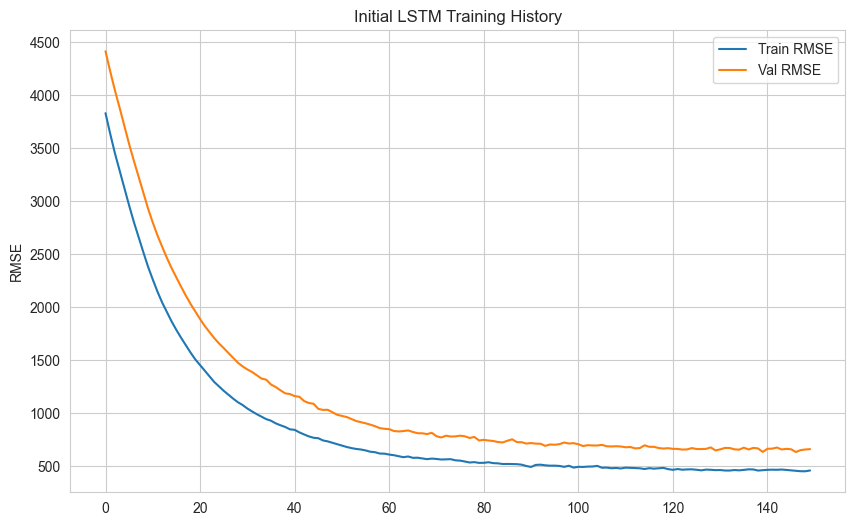

Initial LSTM Test RMSE: 778.81


In [3]:
class RiceYieldLSTM(nn.Module):
    def __init__(self, input_dim, hidden_size=64, n_layers=2, dropout=0.1):
        super(RiceYieldLSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_size,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0.0
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: (batch, seq, feat)
        out, _ = self.lstm(x)
        # Last time step
        out = out[:, -1, :]
        return self.fc(out)

def train_model(model, train_loader, X_val, y_val, epochs=100, lr=0.001, patience=15):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    history = {'rmse': [], 'val_rmse': []}
    best_rmse = float('inf')
    patience_counter = 0
    best_weights = None
    
    for epoch in range(epochs):
        model.train()
        batch_losses = []
        for X_b, y_b in train_loader:
            optimizer.zero_grad()
            pred = model(X_b)
            loss = criterion(pred, y_b.unsqueeze(1))
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
            
        # Val
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = criterion(val_pred, y_val.unsqueeze(1))
            val_rmse = np.sqrt(val_loss.item())
            
        history['rmse'].append(np.sqrt(np.mean(batch_losses)))
        history['val_rmse'].append(val_rmse)
        
        if val_rmse < best_rmse:
            best_rmse = val_rmse
            best_weights = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            break
            
    if best_weights: model.load_state_dict(best_weights)
    return history

# --- INITIAL MODEL (Updated Params) ---
# Params from previous Optuna tuning (rounded)
init_params = {
    'hidden_size': 192,
    'n_layers': 2,
    'dropout': 0.28,
    'learning_rate': 0.027,
    'batch_size': 64
}

train_ds = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_ds, batch_size=init_params['batch_size'], shuffle=True)

model_init = RiceYieldLSTM(
    input_dim=X_train_t.shape[2], 
    hidden_size=init_params['hidden_size'], 
    n_layers=init_params['n_layers'],
    dropout=init_params['dropout']
).to(device)

print("Training Initial LSTM (Seq Len=3)...")
hist_init = train_model(
    model_init, train_loader, X_val_t, y_val_t, 
    epochs=150, 
    lr=init_params['learning_rate'], 
    patience=15
)

plt.figure(figsize=(10, 6))
plt.plot(hist_init['rmse'], label='Train RMSE')
plt.plot(hist_init['val_rmse'], label='Val RMSE')
plt.title('Initial LSTM Training History')
plt.ylabel('RMSE')
plt.legend()
plt.show()

# Init Eval
model_init.eval()
with torch.no_grad():
    init_pred = model_init(X_test_t).cpu().numpy().flatten()
rmse_init = np.sqrt(mean_squared_error(y_test_raw, init_pred))
print(f"Initial LSTM Test RMSE: {rmse_init:.2f}")

### 3. Optuna Optimization
Tuning with sequence-based data.

In [4]:
def objective(trial):
    hidden_size = trial.suggest_int('hidden_size', 32, 256, step=32)
    n_layers = trial.suggest_int('n_layers', 1, 3)
    dropout = trial.suggest_float('dropout', 0.0, 0.4)
    lr = trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    
    ds = TensorDataset(X_train_t, y_train_t)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=True)
    
    model = RiceYieldLSTM(
        input_dim=X_train_t.shape[2], 
        hidden_size=hidden_size,
        n_layers=n_layers,
        dropout=dropout
    ).to(device)
    
    # Reduced patience for tuning speed
    hist = train_model(model, loader, X_val_t, y_val_t, epochs=80, lr=lr, patience=8)
    return min(hist['val_rmse'])

study = optuna.create_study(direction='minimize', study_name='Rice_LSTM_Seq3')
study.optimize(objective, n_trials=20)

print("Best Params:", study.best_params)
fig = plot_optimization_history(study)
fig.show()

[I 2025-11-26 21:53:08,453] A new study created in memory with name: Rice_LSTM_Seq3
[I 2025-11-26 21:53:18,327] Trial 0 finished with value: 609.9176173877911 and parameters: {'hidden_size': 64, 'n_layers': 1, 'dropout': 0.33231865258081106, 'learning_rate': 0.023168596628301202, 'batch_size': 16}. Best is trial 0 with value: 609.9176173877911.
[I 2025-11-26 21:53:33,129] Trial 1 finished with value: 645.4398451831123 and parameters: {'hidden_size': 96, 'n_layers': 1, 'dropout': 0.3579176348713836, 'learning_rate': 0.008727377072226133, 'batch_size': 16}. Best is trial 0 with value: 609.9176173877911.
[I 2025-11-26 21:53:38,941] Trial 2 finished with value: 4358.7316962621135 and parameters: {'hidden_size': 64, 'n_layers': 2, 'dropout': 0.02221657373189814, 'learning_rate': 0.002027342565753166, 'batch_size': 128}. Best is trial 0 with value: 609.9176173877911.
[I 2025-11-26 21:54:05,437] Trial 3 finished with value: 827.0219918478589 and parameters: {'hidden_size': 160, 'n_layers': 3,

Best Params: {'hidden_size': 96, 'n_layers': 1, 'dropout': 0.35438299674614687, 'learning_rate': 0.011184770151329286, 'batch_size': 16}


### 4. Final Model & Results

Training Final Model (Full Data)...

Final LSTM Test RMSE: 664.47 (Improved -26.05%)
Final LSTM Test R2:   0.9104


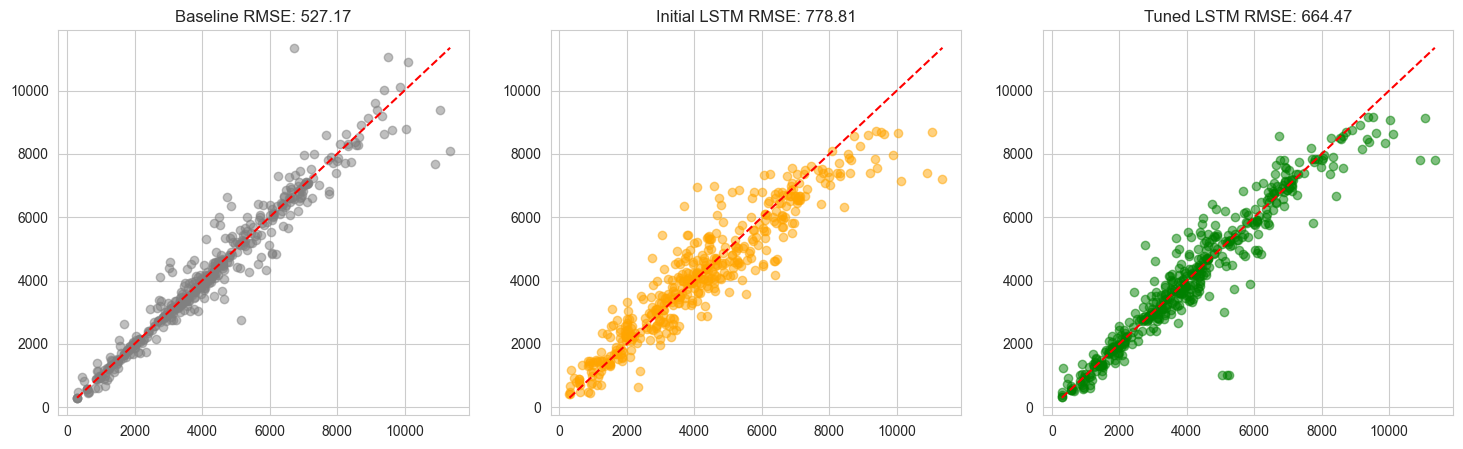

In [5]:
# 1. Combine Train+Val for Final Training
X_final_t = torch.cat([X_train_t, X_val_t], dim=0)
y_final_t = torch.cat([y_train_t, y_val_t], dim=0)

# 2. Params
bp = study.best_params
final_loader = DataLoader(TensorDataset(X_final_t, y_final_t), batch_size=bp['batch_size'], shuffle=True)

# 3. Model
final_model = RiceYieldLSTM(
    input_dim=X_train_t.shape[2], 
    hidden_size=bp['hidden_size'], 
    n_layers=bp['n_layers'],
    dropout=bp['dropout']
).to(device)

# 4. Train
print("Training Final Model (Full Data)...")
optimizer = optim.Adam(final_model.parameters(), lr=bp['learning_rate'])
criterion = nn.MSELoss()

final_model.train()
for epoch in range(150):
    for X_b, y_b in final_loader:
        optimizer.zero_grad()
        pred = final_model(X_b)
        loss = criterion(pred, y_b.unsqueeze(1))
        loss.backward()
        optimizer.step()

# 5. Eval
final_model.eval()
with torch.no_grad():
    final_pred = final_model(X_test_t).cpu().numpy().flatten()

rmse_final = np.sqrt(mean_squared_error(y_test_raw, final_pred))
r2_final = r2_score(y_test_raw, final_pred)
imp = (rmse_base - rmse_final) / rmse_base * 100

print(f"\nFinal LSTM Test RMSE: {rmse_final:.2f} (Improved {imp:.2f}%)")
print(f"Final LSTM Test R2:   {r2_final:.4f}")

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.scatter(y_test_raw, y_base_raw, alpha=0.5, color='gray')
plt.plot([y_test_raw.min(), y_test_raw.max()], [y_test_raw.min(), y_test_raw.max()], 'r--')
plt.title(f'Baseline RMSE: {rmse_base:.2f}')

plt.subplot(1, 3, 2)
plt.scatter(y_test_raw, init_pred, alpha=0.5, color='orange')
plt.plot([y_test_raw.min(), y_test_raw.max()], [y_test_raw.min(), y_test_raw.max()], 'r--')
plt.title(f'Initial LSTM RMSE: {rmse_init:.2f}')

plt.subplot(1, 3, 3)
plt.scatter(y_test_raw, final_pred, alpha=0.5, color='green')
plt.plot([y_test_raw.min(), y_test_raw.max()], [y_test_raw.min(), y_test_raw.max()], 'r--')
plt.title(f'Tuned LSTM RMSE: {rmse_final:.2f}')
plt.show()